In [1]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import tensorflow.contrib.eager as tfe
from functools import partial
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.calibration import calibration_curve
import matplotlib.tri as tri
from scipy.special import betaln
from scipy.stats import beta
from scipy import stats
from scipy.special import gamma as gamma_fun
import scipy.special as spec
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np
from sklearn.metrics import confusion_matrix
np.set_printoptions(suppress=True)


from deep_bayes.models import DeepEvidentialModel
from deep_bayes.settings import EVIDENTIAL_BN
from deep_bayes.training import train_online
from deep_bayes.losses import log_loss
from deep_bayes.diagnostics import accuracy, expected_calibration_error
from deep_bayes.viz import plot_model_samples, plot_confusion_matrix

D:\Anaconda3\envs\TensorFlowGpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3\envs\TensorFlowGpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3\envs\TensorFlowGpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda3\envs\TensorFlowGpu\lib\site-packages\tensorflow\python\framework\dtypes.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
tf.enable_eager_execution()

In [4]:
%matplotlib inline

# Generative model specifications

## Model prior 
<p>Defines the prior probabilities over models $p(\boldsymbol{m})$.</p>

In [5]:
def model_prior(batch_size, n_models, p_vals=None):
    """
    Samples from the models' prior batch size times and converts to one-hot.
    Assumes equal model priors.
    ----------
    
    Arguments:
    batch_size : int  -- the number of samples to draw from the prior
    n_models   : int  -- the number of generative models in queston
    ----------
    
    Returns:
    m_true : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """
    
    # Equal priors, if nothign specified
    if p_vals is None:
        p_vals = [1/n_models] * n_models
    m_idx = np.random.choice(n_models, size=batch_size, p=p_vals).astype(np.int32)
    return m_idx

## Model priors

In [6]:
def model0_prior():
    
    betas = np.random.randn(1)
    return betas

def model1_prior():
    
    betas = np.random.randn(2)
    return betas

def model2_prior():
    
    betas = np.random.randn(3)
    return betas

def model3_prior():
    
    betas = np.random.randn(4)
    return betas

def model4_prior():
    
    betas = np.random.randn(3)
    return betas

In [7]:
def model0(theta, n_obs, sigma=1.0, scale=True):
    """Generates data from y ~N(beta0 e)"""
    
    # Extract params
    beta0 = theta
    
    # Create a design matrix
    x = np.random.randn(n_obs, 1)
    
    # Generate the data
    y = beta0 + np.random.rand(n_obs) * sigma
    
    if scale:
        y = ((y - np.min(y)) / (np.max(y) - np.min(y)) * 2) - 1
    
    return np.c_[x, y]

def model1(theta, n_obs, sigma=1.0, scale=True):
    """Generates data from y ~N(beta0 + beta1*x, e)"""
    
    # Extract params
    beta0, beta1 = theta
    
    # Create a design matrix
    x = np.random.randn(n_obs)
    
    # Generate the data
    y = beta0 + beta1*x + np.random.randn(n_obs) * sigma
    
    if scale:
        y = ((y - np.min(y)) / (np.max(y) - np.min(y))) * 2 - 1
        
    return np.c_[x, y]

def model2(theta, n_obs, sigma=1.0, scale=True):
    """Generates data from y ~N(beta0 + beta1*x, e)"""
    
    # Extract params
    beta0, beta1, beta2 = theta
    
    # Create a design matrix
    x = np.random.randn(n_obs)
    
    # Generate the data
    y = beta0 + beta1*x + beta2*(x**2) + np.random.randn(n_obs) * sigma
    
    if scale:
        y = ((y - np.min(y)) / (np.max(y) - np.min(y))) * 2 - 1
    
    return np.c_[x, y]

def model3(theta, n_obs, sigma=1.0, scale=True):
    """Generates data from y ~N(beta0 + beta1*x + beta2*x**2 + beta3*, e)"""
    
    # Extract params
    beta0, beta1, beta2, beta3 = theta
    
    # Create a design matrix
    x = np.random.randn(n_obs)
    
    # Generate the data
    y = y = beta0 + beta1*x + beta2*(x**2) + beta3*(x**3) + np.random.rand(n_obs) * sigma
    
    if scale:
        y = ((y - np.min(y)) / (np.max(y) - np.min(y))) * 2 - 1
    
    return np.c_[x, y]

def model4(theta, n_obs, sigma=1.0, scale=True):
    """Generates data from y ~N(beta0 + beta1*exp(x + sin(x) + cos(x)), e)"""
    
    # Extract params
    beta0, beta1, beta2 = theta
    
    # Create a design matrix
    x = np.random.randn(n_obs)
    
    # Generate the data
    y = y = beta0 + beta1*x + beta2*np.exp(x + np.sin(x) + np.cos(x)) + np.random.rand(n_obs) * sigma
    
    if scale:
        y = ((y - np.min(y)) / (np.max(y) - np.min(y)) ) * 2 - 1
   
    return np.c_[x, y]

## Data generator

In [358]:
def data_generator(batch_size, model_prior, param_priors, forward_models, alpha_smooth=None,
                   n_obs=None, n_obs_min=100, n_obs_max=500, to_tensor=True, **args):
    """
    Runs the forward model 'batch_size' times by first sampling fromt the prior
    theta ~ p(theta) and running x ~ p(x|theta).
    ----------
    
    Arguments:
    batch_size     : int -- the number of samples to draw from the prior
    model_prior    : callable -- the prior which returns a sample of model indices
    param_priors   : list of callables -- a list with model prior samplers
    forward_models : list of generative models g(theta) -- a list of generatibve models
    n_obs          : int -- the numebr of observations to draw from p(x|theta)
    n_obs_min      : int -- used when n_obs is None, draws n_obs ~ U(n_obs_min, n_obs_max)
    n_obs_max      : int -- used when n_obs is None, draws n_obs ~ U(n_obs_min, n_obs_max)
    to_tensor      : boolean -- converts theta and x to tensors if True
    ----------
    
    Output:
    m     : tf.Tensor or np.ndarray of shape (batch_size, n_models) - the one-hot encoded version of the models
    theta : tf.Tensor or np.ndarray of shape (batch_size, theta_dim) - the data gen parameters 
    x     : tf.Tensor of np.ndarray of shape (batch_size, n_obs, x_dim)  - the generated data
    """
    
    # Sample from model prior
    # m_indices is an np.int32 array of model indices  
    n_models = len(forward_models)
    m_indices = model_prior(batch_size, n_models)
    
    # Sample N, if not specified
    if n_obs is None:
        n_obs = np.random.randint(low=n_obs_min, high=n_obs_max+1)
    
    # For each model index, sample from prior and run generative model.
    x = []
    theta = []
    for m_idx in m_indices:
        
        # Draw from model prior theta ~ p(theta|
        theta_m = param_priors[m_idx]()
        
        # Generate data from x = g_m(theta) <=> x ~ p(x|theta,m)
        x_m = forward_models[m_idx](theta_m, n_obs, **args)
        
        # Store data and params
        x.append(x_m)
        theta.append(theta_m)
    
    # One-hot encode model indices
    m = to_categorical(m_indices, num_classes=n_models)
    
    # Apply label smoothing, if specified
    if alpha_smooth is not None:
        m = m * (1 - alpha_smooth) + alpha_smooth / n_models
    
    # Convert to tensor, if specified 
    if to_tensor:
        x = tf.convert_to_tensor(x, dtype=tf.float32)
        m = tf.convert_to_tensor(m, dtype=tf.float32)
    return {'m': m, 'theta': theta, 'x': x}

# Training hyperparameters (fixed N)

In [381]:
#--- Training hyperparameters ---#
n_obs_min = 10
n_obs_max = 500
n_test = 500
alpha_smooth = None
epochs = 50
iterations_per_epoch = 1000
batch_size = 64
ckpt_file = 'toy_bayesian_regression'

#--- Optimizer hyperparameters ---#
starter_learning_rate = 0.0001
decay_steps = 10000
decay_rate = .99

#--- Data generation ---#
model_names = ['M0', 'M1', 'M2', 'M3', 'M4']
param_priors = [model0_prior, model1_prior, model2_prior, model3_prior, model4_prior]
forward_models = [model0, model1, model2, model3, model4]
data_gen = partial(data_generator, 
                   model_prior=model_prior, 
                   param_priors=param_priors,
                   forward_models=forward_models,
                   n_obs_min=n_obs_min,
                   n_obs_max=n_obs_max,
                   alpha_smooth=alpha_smooth,
                   scale=True)


# --- Optimizer --- #
global_step = tfe.Variable(0, dtype=tf.int32)
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 
                                           decay_steps, decay_rate, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [399]:
### Creae a dataset to use across all methods
np.random.seed(42)
m0_x = [model0(model0_prior(), n_obs=250, scale=False) for _ in range(20)]
m1_x = [model1(model1_prior(), n_obs=250, scale=False) for _ in range(20)]
m2_x = [model2(model2_prior(), n_obs=250, scale=False) for _ in range(20)]
m3_x = [model3(model3_prior(), n_obs=250, scale=False) for _ in range(20)]
m4_x = [model4(model4_prior(), n_obs=250, scale=False) for _ in range(20)]

for i, (m0, m1, m2, m3, m4) in enumerate(zip(m0_x, m1_x, m2_x, m3_x, m4_x)):
    
    df0 = pd.DataFrame(m0, columns=['x', 'y'])
    df1 = pd.DataFrame(m1, columns=['x', 'y'])
    df2 = pd.DataFrame(m2, columns=['x', 'y'])
    df3 = pd.DataFrame(m3, columns=['x', 'y'])
    df4 = pd.DataFrame(m4, columns=['x', 'y'])
    
    df0.to_csv('./sim_data/data_m0_{}.csv'.format(i+1), sep=';', index=False)
    df1.to_csv('./sim_data/data_m1_{}.csv'.format(i+1), sep=';', index=False)
    df2.to_csv('./sim_data/data_m2_{}.csv'.format(i+1), sep=';', index=False)
    df3.to_csv('./sim_data/data_m3_{}.csv'.format(i+1), sep=';', index=False)
    df4.to_csv('./sim_data/data_m4_{}.csv'.format(i+1), sep=';', index=False)

## Create test data and compute true BFs

In [382]:
%%time
test_data = data_gen(n_test, n_obs=500)

Wall time: 299 ms


## Create model

In [383]:
model = DeepEvidentialModel(EVIDENTIAL_BN)

## Manage checkpoints

In [384]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/{}'.format(ckpt_file), max_to_keep=2)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Initializing from scratch.


## Train network

0.776


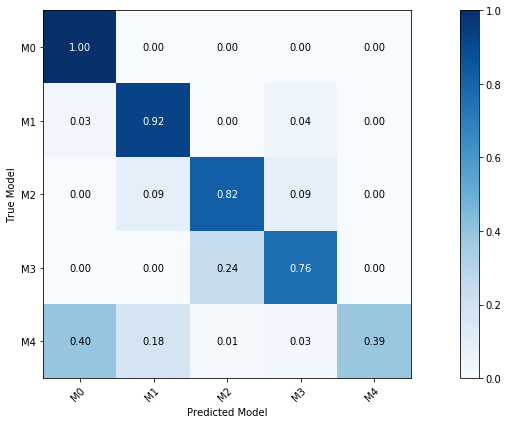

0.794


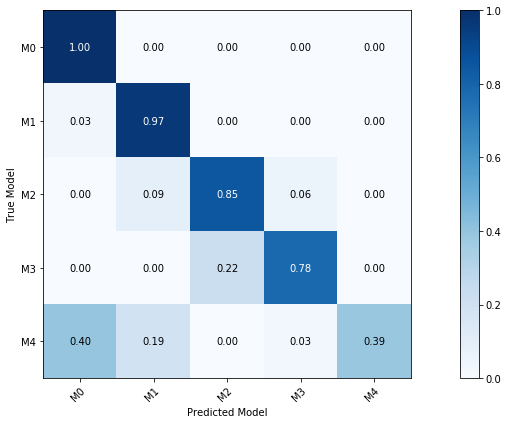

Instructions for updating:
Use standard file APIs to delete files with this prefix.



0.772


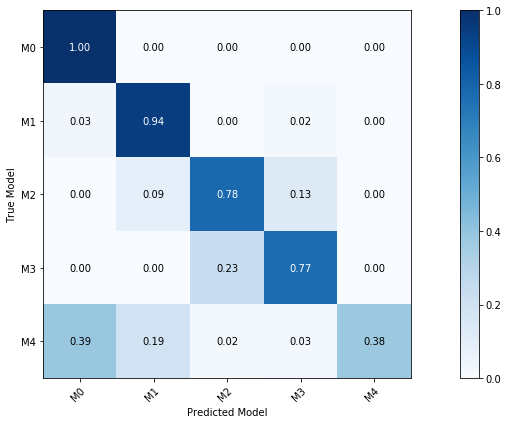

0.78


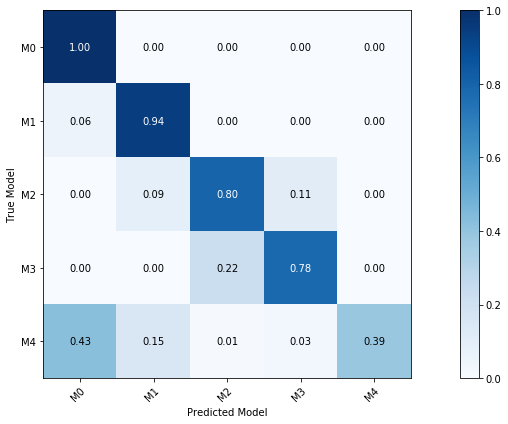

0.782


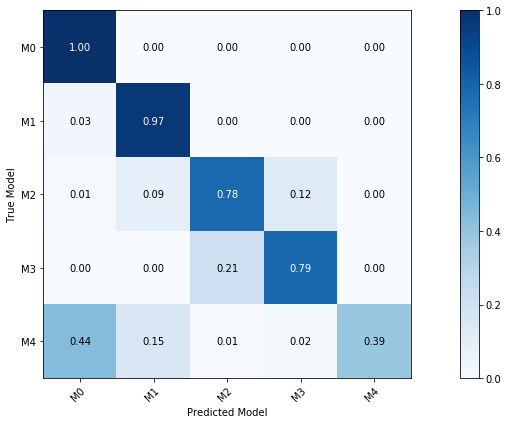

0.76


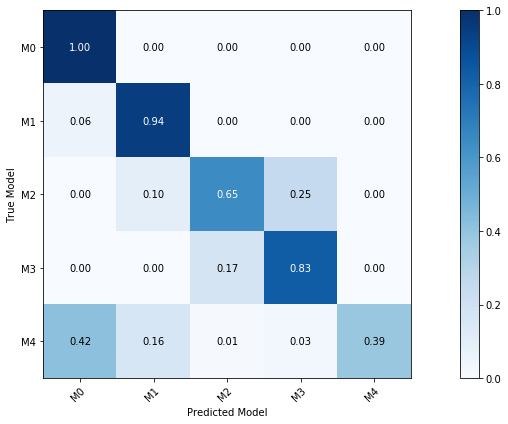

0.772


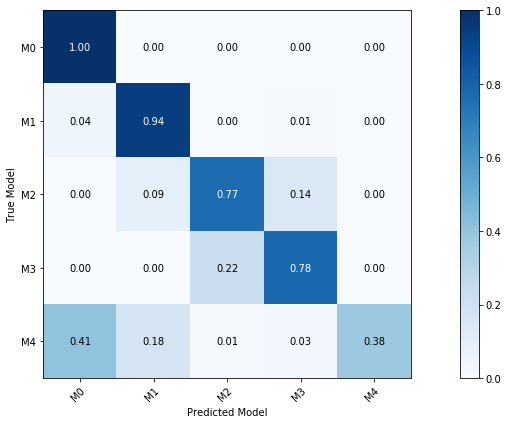

0.778


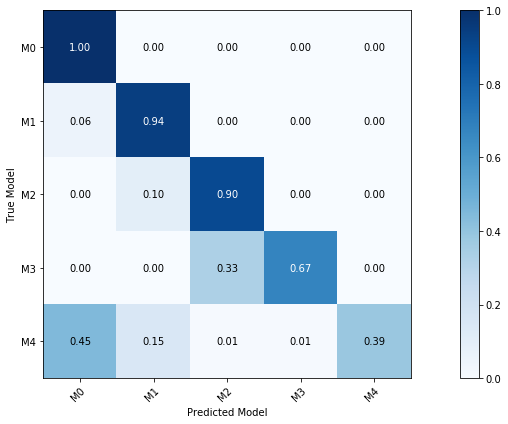

0.788


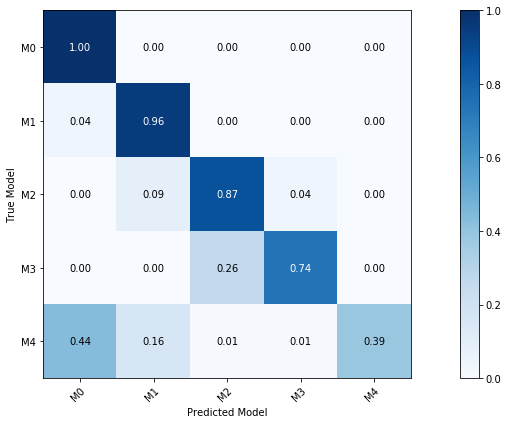

0.792


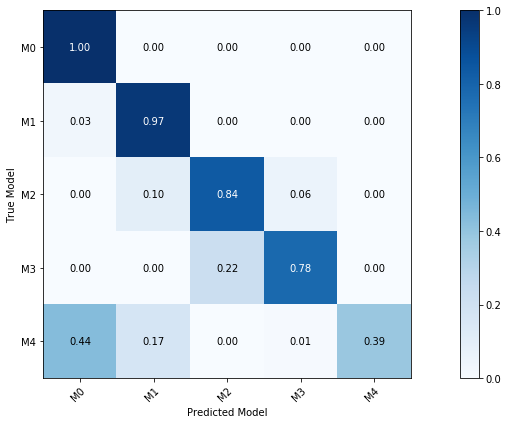


Wall time: 24min 38s


In [386]:
%%time
for ep in range(1, 10+1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        losses = train_online(model=model, 
                              optimizer=optimizer, 
                              data_gen=data_gen, 
                              loss_fun=partial(log_loss, lambd=0), 
                              iterations=iterations_per_epoch,
                              batch_size=batch_size,
                              p_bar=p_bar,
                              global_step=global_step,
                              method='evidence')
        
        # Plot stuff
        m_pred = tf.concat([model(x)['m_probs'] for x in tf.split(test_data['x'], 20, axis=0)], axis=0)
        print(accuracy(test_data['m'], m_pred))
        plot_confusion_matrix(m_pred.numpy().argmax(axis=1), test_data['m'], 
                              model_names, figsize=(14,6), normalize=True)        
        manager.save()

## Evaluate Models

In [402]:
accs = []
accs_stds = []
n_bootstrap = 50
n_val = 1000
n_chunks = 10

for n in range(n_obs_min, n_obs_max+2, 2):
    
    # Obtain probs
    test_data_n = data_gen(n_val, n_obs=n)
    m_probs = np.concatenate([model.predict(x, to_numpy=True)['m_probs'] 
                              for x in tf.split(test_data_n['x'], n_chunks, axis=0)], axis=0)
    
    # Compute bootstrapped probs
    accs_b = []
    for bi in range(n_bootstrap):
        
        # Get bootstrap samples
        b_idx = np.random.choice(np.random.permutation(n_val), size=n_val, replace=True)
        m_test_b = tf.gather(test_data_n['m'], b_idx, axis=0).numpy()
        m_probs_b = tf.gather(m_probs, b_idx, axis=0).numpy()
        acc_b = accuracy(m_test_b, m_probs_b)
        accs_b.append(acc_b)
        
    # Compute true and estimated BFs
    accs.append(np.mean(accs_b))
    accs_stds.append(np.std(accs_b, ddof=1))

Text(0, 0.5, 'Accuracy')

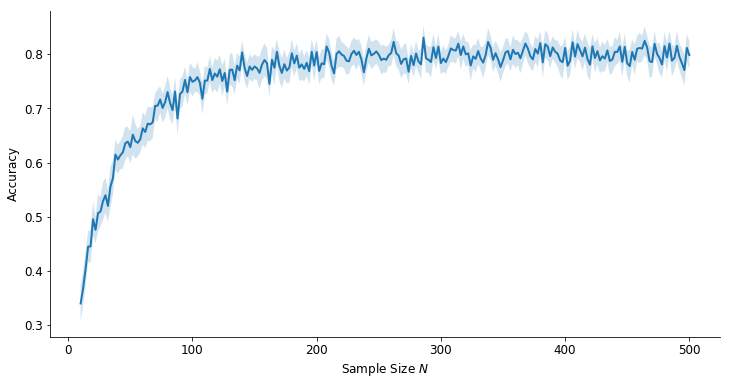

In [405]:
plt.rcParams['font.size'] = 12

# Bayes factors
f, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(range(n_obs_min, n_obs_max+2, 2), accs, lw=2)
ax.fill_between(range(n_obs_min, n_obs_max+2, 2), 
                np.array(accs)-1.98*np.array(accs_stds), 
                np.array(accs)+1.98*np.array(accs_stds), 
                interpolate=True, alpha=0.2)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel(r'Sample Size $N$')
ax.set_ylabel('Accuracy')
# f.savefig('figures/BR_Toy.png', dpi=300, bbox_inches='tight')